In [ ]:
# Core & Utilities
import os
import re
import string
import random
import pickle
from collections import Counter

import numpy as np
import pandas as pd

SEED = 42
np.random.seed(SEED)
random.seed(SEED)


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score,
                                 recall_score, f1_score, matthews_corrcoef,
                                   classification_report, confusion_matrix )


# TensorFlow / Keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import (Embedding,Conv1D,GlobalMaxPooling1D,
                                        LSTM,Bidirectional,Dense,Dropout)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
df = pd.read_csv(r"\HealthAI\data\hospital_reviews\hospital_reviews.csv")
df.head()

,Feedback,Sentiment Label,Ratings
0,Good and clean hospital. There is great team o...,1,5
1,Had a really bad experience during discharge. ...,1,5
2,I have visited to take my second dose and Proc...,1,4
3,That person was slightly clueless and offered...,1,3
4,There is great team of doctors and good OT fac...,0,1


In [3]:
# Dataset shape
print("Dataset shape:", df.shape)

# Column names
print("Columns:", df.columns.tolist())

# Data types
df.info()

# Missing values check
df.isnull().sum()
print(df.columns)

Dataset shape: (996, 3)
Columns: ['Feedback', 'Sentiment Label', 'Ratings']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Feedback         996 non-null    object
 1   Sentiment Label  996 non-null    int64 
 2   Ratings          996 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 23.5+ KB
Index(['Feedback', 'Sentiment Label', 'Ratings'], dtype='object')


In [4]:
df = df.rename(columns={
    "Feedback": "feedback",
    "Sentiment Label": "sentiment",
    "Ratings": "rating"
})

df.head()

,feedback,sentiment,rating
0,Good and clean hospital. There is great team o...,1,5
1,Had a really bad experience during discharge. ...,1,5
2,I have visited to take my second dose and Proc...,1,4
3,That person was slightly clueless and offered...,1,3
4,There is great team of doctors and good OT fac...,0,1


In [5]:
print("Total null values count :", df.isnull().sum().sum())
print("Total duplicates count :", df.duplicated().sum())

Total null values count : 0
Total duplicates count : 19


In [6]:
df_clean = df.drop_duplicates()
df_clean.shape

(977, 3)

In [7]:
# Check empty or whitespace-only feedback
empty_feedback = df_clean["feedback"].str.strip().eq("").sum()
print("Empty feedback rows:", empty_feedback)

Empty feedback rows: 0


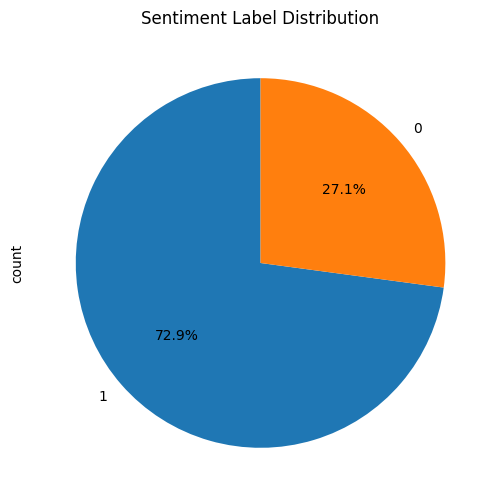

In [8]:
plt.figure(figsize=(6,6))
df_clean["sentiment"].value_counts().plot(kind="pie", autopct = "%1.1f%%", startangle = 90)
plt.title("Sentiment Label Distribution")
plt.show()

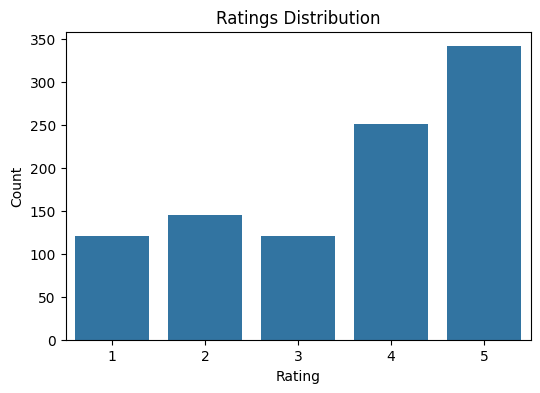

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df_clean)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

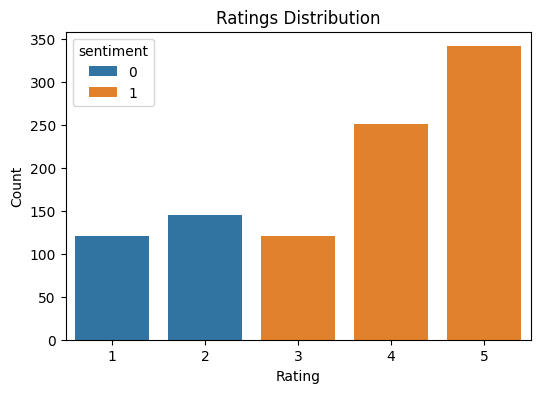

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df_clean, hue="sentiment")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

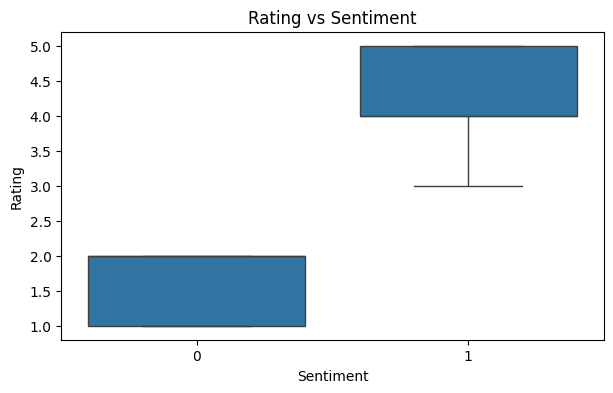

In [11]:
plt.figure(figsize=(7,4))
sns.boxplot(x="sentiment", y="rating", data=df_clean)
plt.title("Rating vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Rating")
plt.show()

In [12]:
df_clean["char_length"] = df_clean["feedback"].str.len()
df_clean["word_length"] = df_clean["feedback"].str.split().apply(len)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27680\2674518562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["char_length"] = df_clean["feedback"].str.len()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27680\2674518562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["word_length"] = df_clean["feedback"].str.split().apply(len)


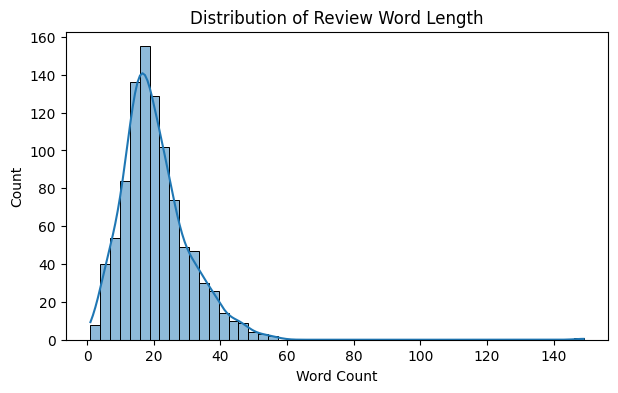

In [13]:
plt.figure(figsize=(7,4))
sns.histplot(df_clean["word_length"], bins=50, kde=True)
plt.title("Distribution of Review Word Length")
plt.xlabel("Word Count")
plt.show()

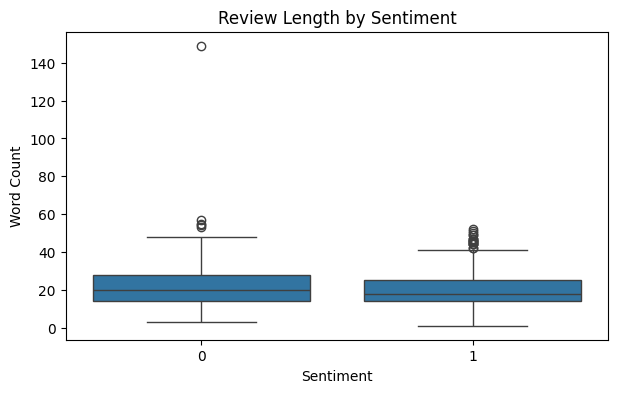

In [14]:
plt.figure(figsize=(7,4))
sns.boxplot(x="sentiment", y="word_length", data=df_clean)
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()

In [15]:


all_words = " ".join(df_clean["feedback"]).lower().split()
common_words = Counter(all_words).most_common(20)

pd.DataFrame(common_words, columns=["Word", "Frequency"])

,Word,Frequency
0,the,898
1,and,886
2,to,451
3,is,395
4,very,364
5,for,331
6,hospital,309
7,i,287
8,a,270
9,are,264


In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"<.*?>", "", text)            # remove HTML tags
    text = re.sub(r"[^a-z\s]", "", text)         # remove special characters & numbers
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces
    return text

In [17]:
df_clean["clean_feedback"] = df_clean["feedback"].apply(clean_text)

df_clean[["feedback", "clean_feedback"]].head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27680\4195300114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["clean_feedback"] = df_clean["feedback"].apply(clean_text)


,feedback,clean_feedback
0,Good and clean hospital. There is great team o...,good and clean hospital there is great team of...
1,Had a really bad experience during discharge. ...,had a really bad experience during discharge t...
2,I have visited to take my second dose and Proc...,i have visited to take my second dose and proc...
3,That person was slightly clueless and offered...,that person was slightly clueless and offered ...
4,There is great team of doctors and good OT fac...,there is great team of doctors and good ot fac...


In [18]:
df_clean["sentiment"].unique()

array([1, 0], dtype=int64)

In [19]:
label_map = {"negative": 0, "positive": 1}
df_clean["sentiment_encoded"] = df_clean["sentiment"].map(label_map)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27680\2962109195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["sentiment_encoded"] = df_clean["sentiment"].map(label_map)


In [20]:
le = LabelEncoder()
df_clean["sentiment_encoded"] = le.fit_transform(df_clean["sentiment"])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27680\2974940130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["sentiment_encoded"] = le.fit_transform(df_clean["sentiment"])


In [21]:
X = df_clean["clean_feedback"]
y = df_clean["sentiment_encoded"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (683,)
Validation size: (147,)
Test size: (147,)


In [ ]:
df_clean.to_csv("\HealthAI\data\hospital_reviews\hospital_reviews_cleaned.csv", index=False)

In [23]:
MAX_VOCAB_SIZE = 20000     # sufficient for this dataset size
MAX_SEQUENCE_LENGTH = 200 # based on EDA review length distribution
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token=OOV_TOKEN
)

tokenizer.fit_on_texts(X_train)



In [24]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)


X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

X_val_pad = pad_sequences(
    X_val_seq,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

In [25]:
print("Train padded shape:", X_train_pad.shape)
print("Validation padded shape:", X_val_pad.shape)
print("Test padded shape:", X_test_pad.shape)


Train padded shape: (683, 200)
Validation padded shape: (147, 200)
Test padded shape: (147, 200)


In [26]:
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print("Vocabulary size:", vocab_size)

Vocabulary size: 2133


In [27]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)



In [28]:
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

baseline_model.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [29]:
y_val_pred = baseline_model.predict(X_val_tfidf)

print("Validation Classification Report (Baseline):\n")
print(classification_report(y_val, y_val_pred))


Validation Classification Report (Baseline):

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        40
           1       0.92      0.93      0.92       107

    accuracy                           0.88       147
   macro avg       0.86      0.85      0.85       147
weighted avg       0.88      0.88      0.88       147



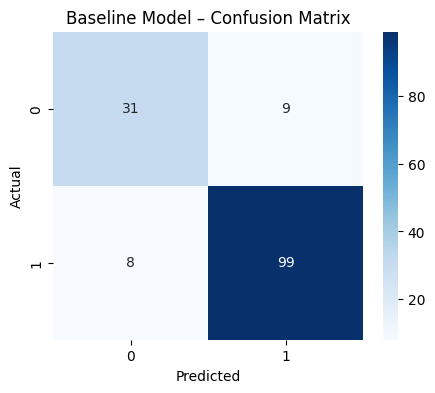

In [30]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_val, y_val_pred), 
            annot=True, fmt="d", cmap="Blues")
plt.title("Baseline Model – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
EMBEDDING_DIM = 128

cnn_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH
    ),
    
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    
    Dense(64, activation="relu"),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")  # binary sentiment
])


In [32]:
cnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7218 - loss: 0.6087 - val_accuracy: 0.7279 - val_loss: 0.5735
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7291 - loss: 0.5482 - val_accuracy: 0.7279 - val_loss: 0.5231
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7496 - loss: 0.4425 - val_accuracy: 0.7959 - val_loss: 0.4201
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9063 - loss: 0.2931 - val_accuracy: 0.8912 - val_loss: 0.2884
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9575 - loss: 0.1564 - val_accuracy: 0.8912 - val_loss: 0.2499
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9810 - loss: 0.0836 - val_accuracy: 0.8776 - val_loss: 0.2940
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9883 - loss: 0.0547 - val_accuracy: 0.8844 - val_loss: 0.3132
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9883 - loss: 0.0425 - val_accuracy: 0.8844 - v

In [34]:
val_loss, val_acc = cnn_model.evaluate(X_val_pad, y_val, verbose=0)
print(f"CNN Validation Accuracy: {val_acc:.4f}")

CNN Validation Accuracy: 0.8912


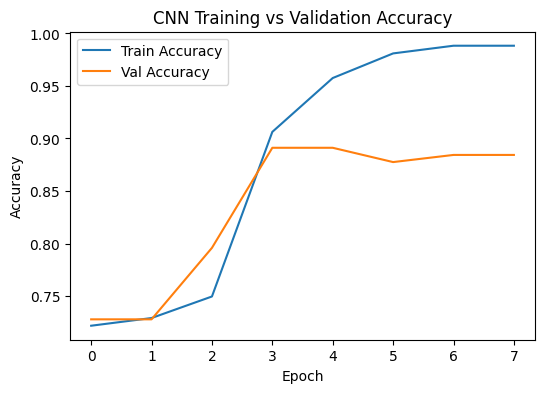

In [35]:
plt.figure(figsize=(6,4))
plt.plot(history_cnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_cnn.history["val_accuracy"], label="Val Accuracy")
plt.title("CNN Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [36]:


lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH
    ),
    
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    
    Dense(64, activation="relu"),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")
])



In [37]:
lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
lstm_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
history_lstm = lstm_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

val_loss_lstm, val_acc_lstm = lstm_model.evaluate(X_val_pad, y_val, verbose=0)
print(f"LSTM Validation Accuracy: {val_acc_lstm:.4f}")


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.7262 - loss: 0.6144 - val_accuracy: 0.7279 - val_loss: 0.5772
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7291 - loss: 0.5642 - val_accuracy: 0.7279 - val_loss: 0.5237
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7716 - loss: 0.4581 - val_accuracy: 0.7891 - val_loss: 0.4330
LSTM Validation Accuracy: 0.7279


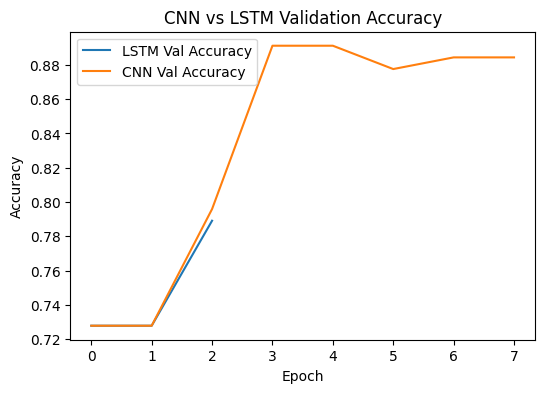

In [39]:
plt.figure(figsize=(6,4))
plt.plot(history_lstm.history["val_accuracy"], label="LSTM Val Accuracy")
plt.plot(history_cnn.history["val_accuracy"], label="CNN Val Accuracy")
plt.title("CNN vs LSTM Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [40]:
# CNN predictions
y_test_pred_cnn = (cnn_model.predict(X_test_pad) > 0.5).astype(int).ravel()

# Metrics
cnn_accuracy = accuracy_score(y_test, y_test_pred_cnn)
cnn_precision = precision_score(y_test, y_test_pred_cnn)
cnn_recall = recall_score(y_test, y_test_pred_cnn)
cnn_f1 = f1_score(y_test, y_test_pred_cnn)
cnn_mcc = matthews_corrcoef(y_test, y_test_pred_cnn)

print("CNN Evaluation Metrics")
print(f"Accuracy  : {cnn_accuracy:.4f}")
print(f"Precision : {cnn_precision:.4f}")
print(f"Recall    : {cnn_recall:.4f}")
print(f"F1-score  : {cnn_f1:.4f}")
print(f"MCC       : {cnn_mcc:.4f}")

print("\nCNN Classification Report:\n")
print(classification_report(y_test, y_test_pred_cnn))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN Evaluation Metrics
Accuracy  : 0.8435
Precision : 0.8443
Recall    : 0.9626
F1-score  : 0.8996
MCC       : 0.5776

CNN Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.53      0.65        40
           1       0.84      0.96      0.90       107

    accuracy                           0.84       147
   macro avg       0.84      0.74      0.77       147
weighted avg       0.84      0.84      0.83       147



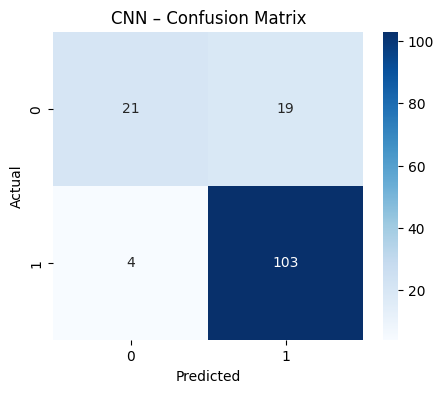

In [41]:
plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_test_pred_cnn),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("CNN – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [42]:
# LSTM predictions
y_test_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype(int).ravel()

# Metrics
lstm_accuracy = accuracy_score(y_test, y_test_pred_lstm)
lstm_precision = precision_score(y_test, y_test_pred_lstm)
lstm_recall = recall_score(y_test, y_test_pred_lstm)
lstm_f1 = f1_score(y_test, y_test_pred_lstm)
lstm_mcc = matthews_corrcoef(y_test, y_test_pred_lstm)

print("LSTM Evaluation Metrics")
print(f"Accuracy  : {lstm_accuracy:.4f}")
print(f"Precision : {lstm_precision:.4f}")
print(f"Recall    : {lstm_recall:.4f}")
print(f"F1-score  : {lstm_f1:.4f}")
print(f"MCC       : {lstm_mcc:.4f}")

print("\nLSTM Classification Report:\n")
print(classification_report(y_test, y_test_pred_lstm))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
LSTM Evaluation Metrics
Accuracy  : 0.7279
Precision : 0.7279
Recall    : 1.0000
F1-score  : 0.8425
MCC       : 0.0000

LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.73      1.00      0.84       107

    accuracy                           0.73       147
   macro avg       0.36      0.50      0.42       147
weighted avg       0.53      0.73      0.61       147



d:\Guvi\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Guvi\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Guvi\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


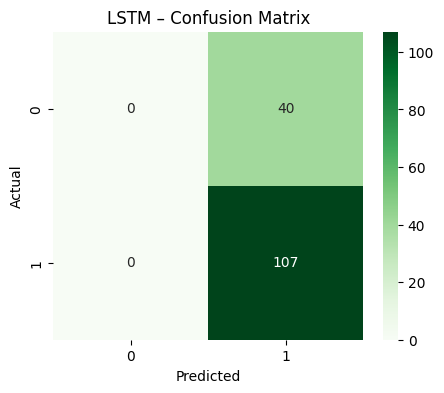

In [43]:
plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_test_pred_lstm),
    annot=True,
    fmt="d",
    cmap="Greens"
)
plt.title("LSTM – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [44]:
comparison_df = pd.DataFrame({
    "Model": ["CNN", "LSTM"],
    "Accuracy": [cnn_accuracy, lstm_accuracy],
    "Precision": [cnn_precision, lstm_precision],
    "Recall": [cnn_recall, lstm_recall],
    "F1-score": [cnn_f1, lstm_f1],
    "MCC": [cnn_mcc, lstm_mcc]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-score,MCC
0,CNN,0.843537,0.844262,0.962617,0.899563,0.577631
1,LSTM,0.727891,0.727891,1.000000,0.842520,0.000000


In [45]:
error_samples = pd.DataFrame({
    "Review": X_test.values,
    "True Label": y_test.values,
    "CNN Prediction": y_test_pred_cnn,
    "LSTM Prediction": y_test_pred_lstm
})

error_samples[error_samples["True Label"] != error_samples["LSTM Prediction"]].head(10)

,Review,True Label,CNN Prediction,LSTM Prediction
10,worst experience when we went for the full bod...,0,0,1
11,the billing and admission department people ha...,0,0,1
18,if you are choosing this hospital for treatmen...,0,1,1
19,the quality of the hos has tumbled down drasti...,0,0,1
21,no response from management properly and every...,0,1,1
22,the food is not tasty and is not made well thi...,0,1,1
28,the doctor who conducted my fathers surgery wa...,0,1,1
38,i went to the hospital for minor symptoms like...,0,0,1
41,review is for master health checkup,0,0,1
42,recently visited this hospital doctors are ext...,0,1,1


In [ ]:
# Save CNN model
cnn_model.save(r"\HealthAI\models\sentiment_analysis\cnn_sentiment_model.keras")

# Save tokenizer
with open(r"\HealthAI\models\sentiment_analysis\cnn_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("CNN model and tokenizer saved successfully.")

CNN model and tokenizer saved successfully.
